In [2]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git
! pip install datasets transformers
! pip install seaborn

# Used for CLIP:
import clip
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import copy
import numpy as np


#Used for testing:
import boto3
from pathlib import Path
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm
from PIL import Image
from dataclasses import dataclass, asdict
from typing import List, Dict
import os
import json
from torch.utils.data import Subset


#Used for visualizing results
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from ipywidgets import widgets, interactive_output, Dropdown, Output, VBox, Button
from IPython.display import display  

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-z_2c5y17
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-z_2c5y17
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/opt/conda/lib/python3.10/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

# CLIPModel Class Method Explanations

## Constructor
- **`__init__(self, model_name='ViT-B/32', device=None)`**
  - Initializes the model with a specified model name and device. Defaults to using CUDA if available. It sets up the optimizer and default parameters for the model. And casts it to float 32 to use ADAM. Also sets a `changeseed` to be able to have different random generations in a loop for Entropy Boosting.

## Optimizer Methods
- **`use_ADAM(self)`**
  - Changes the optimizer of the model to ADAM.
- **`use_SGD(self)`**
  - Switches the optimizer to SGD.
- **`convert_model_parameters_to_float32(self, model)`**
    - This is for ADAM to work. Converts all model parameters to float32 data type.
- **`grad_descent_step(self, loss)`**
    - Performs a single gradient descent step using the computed loss, updating the model parameters accordingly. This is what modifies the clip model stored in the object.

## Gradient Handling
- **`require_CLIP_gradients(self, state=True)`**
  - Enables or disables the calculation of gradients for model parameters based on the specified state.

## Data Handling
- **`load_data(self)`**
  - This is just to have some data easy to access to test the methods on some image. Loads the CIFAR100 dataset which is useful for testing or validating the model performance on image data.
 
## Tokenization of labels
- **`tokenize_labels(self, classes)`**
    - Converts a list of class labels into text tokens using CLIP's tokenizer and encodes them into text features. This is used for matching text descriptions with images. For now this is just used with a photo of a {class} and then stored as an attribute so that we can reuse it for every method.
 
## Transformations
- **`augment_image(self, image, num_augmentations=100, transformations=None)`**
  - Applies specified transformations to an image (or a random transformation if none given) to generate multiple augmented versions.

## Feature and Probability Computations
- **`cos_sim(self, image_features, text_features)`**
  - Calculates the cosine similarity between image and text features.
- **`logits(self, image_features, text_features)`**
  - Computes the logits by applying a scale factor (temperature already learned by CLIP) to the cosine similarities.
- **`class_probabilities(self, image_features, text_features)`**
  - Converts logits to class probabilities using the softmax function.

## Entropy and Loss Calculations
- **`compute_entropy(self, x)`**
  - Computes the Shannon entropy of a probability distribution, measuring uncertainty.
- **`marginal_entropy(self, logits)`**
    - Calculates the marginal entropy of the logits, which quantifies the uncertainty or spread of the predicted probabilities across different classes.
- **`entropy_loss_MEMO(self, batch_features, text_features=None)`**
  - Calculates the entropy loss for the MEMO strategy using marginal entropy.
- **`entropy_loss_TPT(self, batch_features, text_features=None)`**
    - Calculates and returns the entropy loss for TPT.

## Predictions with the CLIP model out of the box
- **`forward(self, image)`**
    - Processes an image through the model, encoding it into image features, normalizing these features, and then computing the class probabilities.
- **`predict(self, image)`**
    - Completes the prediction process including preprocessing the image, computing probabilities, and determining the most probable class along with its entropy. This is what you can use to compute CLIP out of the box predictions.

## Methods used to get predictions
- **`MEMO(self, image, num_augmentations=100)`**
  - Implements MEMO strategy by optimizing model parameters to minimize entropy across predictions.
- **`TPT(self, image, num_augmentations=100)`**
    - Applies the TPT strategy, focusing on refining the model's ability to predict with high certainty by averaging probabilities across "good" augmentations.
- **`entropyboosting(self, image, num_augmentations=100, num_candidates=10, top_aug_num=5)`**
  - Uses "Entropy Boosting" to enhance model confidence by iterating over augmentation cycles to stabilize and improve prediction certainty.

## Extra for TPT
- **`confidence_selection(self, probs_matrix, percentile=0.8)`**
    - Selects predictions with entropy below a specified percentile, filtering out less confident (high entropy) predictions to focus on more certain outcomes.

# Extra for Entropy Boosting
- **`pick_candidates(self, tensor, classifier, top_num)`**
    - Selects top candidates based on a classifier score.
- **`expand_tensor(self, tensor, top_indices, n)`**
    - Expands a smaller tensor into a larger one based on specified indices.
- **`generate_augmentations_similarities(self, image, image_features, txt_candidates, num_augmentations, top_aug_num)`**
    - Generates and evaluates the similarity of augmented images to text candidates, aiding in the identification of most relevant image features.
- **`boost_augmentations(self, image, image_features, prob, num_augmentations, num_candidates, top_aug_num)`**
    - Boosts the confidence in model predictions by blending probabilities from original and augmented images, focusing on candidates with high initial probabilities.




# How to split the CLass:
We have a parent class CLIP and 3 children (for now) which are MEMO, TPT and EB (Entropy Boost). Somehow, those children should be able to interact and use the same CLIP object )(access its attributes, methods as if they where the same object) without creating a copy of it. Not sure how to do it, but ideally it would work like one single class but splitting the code accross multiple classes so that we can structure the code better.
## Attributes:
- device (CLIP)
- model (CLIP)
- preprocess (CLIP)
- optimizer (CLIP)
- text_features (CLIP)
- requiring_grads (CLIP)
- logit_scale (CLIP)
- changeseed 

## Methods:
- __init__ (CLIP has exactly the one written)
- use_ADAM (CLIP)
- use_SGD (CLIP)
- require_CLIP_gradients (CLIP)
- convert_model_parameters_to_float32 (CLIP)
- load_data (this one does not matter, won't be in the final version)
- tokenize_labels (CLIP)
- augment_image (CLIP)
- cos_sim (CLIP)
- logits (CLIP)
- class_probabilities (CLIP)
- marginal_entropy (CLIP)
- compute_entropy (CLIP)
- confidence_selection (TPT)
- entropy_loss_MEMO (MEMO)
- entropy_loss_TPT (TPT)
- forward (CLIP)
- predict (CLIP)
- grad_descent_step (CLIP)
- MEMO (MEMO)
- TPT (TPT)
- pick_candidates (EB)
- expand_tensor (EB)
- generate_augmentations_similarities (EB)
- boost_augmentations (EB)
- entropyboosting (EB)


In [ ]:
class CLIPModel:

    def __init__(self, model_name='ViT-B/32', device=None):
        self.device = device if device else "cuda" if torch.cuda.is_available() else "cpu"
        self.model, self.preprocess = clip.load(model_name, self.device)
        self.model = self.convert_model_parameters_to_float32(self.model)
        self.optimizer = optim.SGD(self.model.parameters(), lr=1e-5, momentum=0.9)
        self.text_features = None
        self.requiring_grads = None
        self.logit_scale = self.model.logit_scale #temperature parameter learned by CLIP
        self.changeseed = 0 #This is to be able to do diverse random transforms but replicable
    
    def use_ADAM(self):
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-5)

    def use_SGD(self):
        self.optimizer = optim.SGD(self.model.parameters(), lr=1e-5, momentum=0.9)

    def require_CLIP_gradients(self, state = True):
        if self.requiring_grads is None or state != self.requiring_grads: #don't change if the state is already OK
            for param in self.model.parameters():
                param.requires_grad = state
            self.requiring_grads = state

    def convert_model_parameters_to_float32(self, model):
        for param in model.parameters():
            param.data = param.data.to(torch.float32)
        return model

    def load_data(self):
        cifar100 = torchvision.datasets.CIFAR100(root='./data', download=True, train=False)
        return cifar100

    #This are heuristic labels
    def tokenize_labels(self, classes):
        text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in classes]).to(self.device)
        with torch.no_grad():
            self.text_features = self.model.encode_text(text_inputs)
            self.text_features /= self.text_features.norm(dim=-1, p=2, keepdim=True)

    def augment_image(self, image, num_augmentations=100, transformations=None):
        if transformations==None:
            torch.manual_seed(33)#Set a seed for reproducibility of the random augmentations
            augmentations = transforms.Compose([
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5),
                transforms.RandomRotation(degrees=30),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
                transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
            ])
        augmented_images = [self.preprocess(image).unsqueeze(0).to(self.device)] #Add the original image to the batch of augmentations
        for _ in range(num_augmentations):
            augmented_images.append(self.preprocess(augmentations(image)).unsqueeze(0).to(self.device))
        batch = torch.vstack(augmented_images)
        return batch #(num_augumentations + 1, 3, 224, 224)

    def cos_sim(self, image_features, text_features):
        return  image_features @ text_features.T

    def logits(self, image_features, text_features):
        logit_scale = self.logit_scale.exp()
        return logit_scale * self.cos_sim(image_features, text_features)

    def class_probabilities(self, image_features, text_features):
        #Compute cosine similarities
        return  self.logits(image_features, text_features).softmax(dim=-1)

    def marginal_entropy(self, logits):
        z = logits - logits.logsumexp(dim = -1, keepdim=True) # compute z_ij
        marginal_logp = z.logsumexp(dim=0) - np.log(z.shape[0])   # compute marginal log probabilities

        min_real = torch.finfo(marginal_logp.dtype).min # for numerical stability,
        # the smallest representable number given the dtype of logits.
        avg_logits = torch.clamp(marginal_logp, min = min_real)  # put a threshold to avoid underflow

        return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

    def compute_entropy(self, x): #Shanon entropy in bits
        #This computes the Shanon entropy
        log_x = torch.log2(x.clamp_min(1e-20))
        entropy = -torch.sum(x * log_x)
        return entropy

    def confidence_selection(self, probs_matrix, percentile=0.8):
        # Compute entropies for each row in the probability matrix
        entropies = torch.tensor([self.compute_entropy(row) for row in probs_matrix])

        # Find the threshold for the desired percentile
        threshold = torch.quantile(entropies, percentile, interpolation = 'linear')

        # Create a boolean mask where entropies below the threshold are selected
        boolean_mask = entropies < threshold

        # Assuming similarities is intended to be probs_matrix, return filtered matrix
        return probs_matrix[boolean_mask]

    def entropy_loss_MEMO(self, batch_features, text_features = None):
        if text_features is None:
            text_features = self.text_features
        #Logits (unnormalized probabilities)
        logits = self.logits(batch_features, text_features)
        # Compute the entropy of every text caption accross all augmentations
        marginal_entropy = self.marginal_entropy(logits)
        return marginal_entropy

    def entropy_loss_TPT(self, batch_features, text_features = None):
        if text_features is None:
            text_features = self.text_features
        probs_matrix = self.class_probabilities(batch_features, text_features)
        # Confidence selection for the augmented views:
        probs_matrix = self.confidence_selection(probs_matrix)
        # Average the caption probabilities across all augmentations
        avg_probs = torch.tensor([row.mean() for row in probs_matrix.T])
        # Compute the entropy of the averaged probability distribution
        return self.compute_entropy(avg_probs), avg_probs

    def forward(self, image):
        image_features = self.model.encode_image(image)
        norms = image_features.norm(dim=-1, p=2,  keepdim=True)
        if (norms == 0).any():
            print("Zero norm found in image features")
        image_features = image_features / norms.clamp_min(1e-10)
        return self.class_probabilities(image_features, self.text_features)

    def predict(self, image):
        self.model.eval()
        image = self.preprocess(image).unsqueeze(0).to(self.device)
        with torch.no_grad():
            probs = self.forward(image)

        prediction = torch.argmax(probs).item()
        entropy = float(self.compute_entropy(probs))
        return prediction, probs.squeeze(), entropy

    def grad_descent_step(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def MEMO(self, image, num_augmentations=100):
        # Save original parameters
        original_params = {name: param.clone() for name, param in self.model.named_parameters()}

        # Require gradients to update the CLIP parameters
        self.require_CLIP_gradients(state = True)

        try:
            self.model.train()
            batch = self.augment_image(image, num_augmentations)
            batch_features = self.model.encode_image(batch)
            norms = batch_features.norm(dim=-1, p=2, keepdim=True)
            if (norms == 0).any():
                print("Zero norm found in image features")
            batch_features = batch_features / norms.clamp_min(1e-10)
            loss = self.entropy_loss_MEMO(batch_features)
            self.grad_descent_step(loss)

            if any(torch.isnan(param).any() for param in self.model.parameters()):
                print("nan values detected in model parameters after updating")
            # Predict using the updated model
            prediction, probs, entropy = self.predict(image)
        finally:
            # Restore original parameters
            with torch.no_grad():
                for name, param in self.model.named_parameters():
                    param.copy_(original_params[name])
        return prediction, probs.squeeze(), entropy

    def TPT(self, image, num_augmentations=100):
        self.model.eval()
        self.require_CLIP_gradients(False)
        batch = self.augment_image(image, num_augmentations)
        batch_features = self.model.encode_image(batch)
        norms = batch_features.norm(dim=-1, p=2, keepdim=True)
        if (norms == 0).any():
            print("Zero norm found in image features")
        batch_features = batch_features / norms.clamp_min(1e-10)

        entropy, avg_probs = self.entropy_loss_TPT(batch_features)
        prediction = torch.argmax(avg_probs).item()
        return prediction, avg_probs.squeeze(), float(entropy)

    #Implementing the Entropy Boost stuff:
    def pick_candidates(self, tensor, classifier, top_num):
        # to select a subset of "candidates" from a given tensor based on scores provided by a classifier
        _, top_indices = torch.topk(classifier, top_num)
        candidates = torch.squeeze(tensor[top_indices])
        
        return candidates, top_indices

    def expand_tensor(self, tensor, top_indices, n):
    
        exp_tensor = torch.zeros(n).to(self.device)
        for i in range(top_indices.shape[0]): exp_tensor[top_indices[i]] = tensor[i]
    
        return exp_tensor

    def generate_augmentations_similarities(self, image, image_features, txt_candidates, num_augmentations, top_aug_num):
        # augment
        torch.manual_seed(33+self.changeseed)
        augmentations = transforms.Compose([
                                transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0), ratio=(0.75, 1.333)),
                                ])
        batch = self.augment_image(image, num_augmentations)
        batch_features = self.model.encode_image(batch)
        norms = batch_features.norm(dim=-1, p=2, keepdim=True)
        if (norms == 0).any():
            print("Zero norm found in image features")
        batch_features = batch_features / norms.clamp_min(1e-10)

    
        # pick the ones closest to the original image
        probs_matrix = self.class_probabilities(image_features, batch_features).squeeze()
        candidates_features, top_indices_aug = self.pick_candidates(batch_features, probs_matrix, top_num = top_aug_num)

        candidates_probs_matrix = self.class_probabilities(candidates_features, txt_candidates).squeeze()
    
        del batch # avoid Cuda to run out of memory?
        return torch.mean(candidates_probs_matrix, dim=0)
    
    def boost_augmentations(self, image, image_features, prob, num_augmentations, num_candidates, top_aug_num):
    
        _, top_indices = torch.topk(prob, num_candidates)
        text_candidates = self.text_features[top_indices]
    
        n = prob.shape[0]

        #Candidates probabilities in the original image
        candidates_prob_og = self.class_probabilities(image_features, text_candidates).squeeze()
        candidates_prob_og = self.expand_tensor(candidates_prob_og, top_indices, n)

        #Candidates averaged probability in the augmentations
        candidates_avg_prob = self.generate_augmentations_similarities(image, image_features, text_candidates, num_augmentations, top_aug_num)
        candidates_avg_prob = self.expand_tensor(candidates_avg_prob, top_indices, n)
    
        return candidates_prob_og, candidates_avg_prob

    def entropyboosting(self, image, num_augmentations = 100, num_candidates = 10, top_aug_num = 5):
        self.model.eval()
        self.require_CLIP_gradients(False)
        if num_candidates <= 1:
            print("If num_candidates=0 this is just CLIP")
            return
        image_prepro = self.preprocess(image).unsqueeze(0).to(self.device)
        image_features = self.model.encode_image(image_prepro)
        norms = image_features.norm(dim=-1, p=2,  keepdim=True)
        image_features = image_features / norms.clamp_min(1e-10)

        #Compute out of the box CLIP probability distribution and prediction
        clip_probs = self.class_probabilities(image_features, self.text_features).squeeze()
        clip_prediction = torch.argmax(clip_probs).item()

        phi = 2 / (1 + np.sqrt(5)) # Aura section - math fetish but it seems to work so...
        
        # Defining loop variables
        aug_prob = None #Should this be an input of the method??
        output_prob = clip_probs.clone() #Is this necessary??
        max_iter = 4
        iter = 0
        while iter < max_iter:
            self.changeseed = self.changeseed + 1 #To make different random transformations at every iter but replicable
            candidates_prob_og, candidates_avg_prob = self.boost_augmentations(image, image_features, output_prob, num_augmentations, num_candidates, top_aug_num)
            
            clip_probs = phi * clip_probs + (1 - phi) * candidates_prob_og #Why are we doing this to the clip probs?
            
            if aug_prob == None: aug_prob = candidates_avg_prob
            else:                aug_prob = 0.5 * aug_prob + 0.5 * candidates_avg_prob
            
            output_prob = 0.6 * clip_probs + 0.4 * aug_prob # give a little more weight to the probability of the image.
            EB_prediction = torch.argmax(output_prob).item()
            
            # if clip_prediction != EB_prediction then it changed its mind: the class with highest probability has changed - better do further checks.
            if clip_prediction == EB_prediction: break

            iter += 1
        self.changeseed = 0
        entropy = self.compute_entropy(output_prob)
        return EB_prediction, output_prob.squeeze(), float(entropy)


# Preparing the class for usage
clip_model = CLIPModel()

1 IMAGE TRIES ON CLIP, MEMO, TPT and EB :)

In [14]:
#Loading CIFAR100 for one image tries_
cifar100 = clip_model.load_data()
clip_model.tokenize_labels(cifar100.classes)
image, class_id = cifar100[3637]
len(cifar100.classes)

Files already downloaded and verified


100

In [16]:
#Try entropyboosting
prediction, probs, entropy = clip_model.entropyboosting(image)
print(prediction)
print(entropy)
print(probs)

78
2.208749294281006
tensor([4.4409e-04, 2.0257e-03, 1.7850e-03, 6.7053e-05, 6.8302e-05, 1.2799e-04,
        2.1407e-04, 8.0405e-03, 3.6831e-05, 1.3982e-04, 3.8572e-04, 3.0443e-04,
        1.2713e-05, 3.9793e-05, 7.2395e-04, 5.2543e-05, 6.3892e-04, 1.7170e-05,
        1.5631e-03, 3.5367e-04, 1.0214e-04, 4.6957e-04, 1.1729e-04, 1.9360e-05,
        2.2551e-04, 6.2725e-05, 2.7089e-03, 4.3508e-02, 2.1955e-04, 1.7460e-03,
        4.6290e-06, 1.6038e-04, 1.2927e-02, 3.8837e-05, 5.5391e-06, 2.1283e-04,
        3.4115e-04, 4.3326e-05, 3.8308e-05, 9.3167e-05, 4.4401e-04, 2.5278e-03,
        1.5629e-02, 3.2312e-04, 4.5569e-02, 5.2967e-05, 1.3752e-04, 4.2287e-05,
        3.7950e-05, 1.7290e-04, 2.4531e-03, 1.0843e-03, 2.3604e-04, 2.8239e-04,
        4.5561e-05, 5.3201e-05, 3.1678e-04, 5.2178e-05, 9.5018e-05, 5.7305e-04,
        3.0544e-04, 6.4293e-04, 2.1116e-04, 1.2552e-04, 1.8514e-04, 2.5836e-04,
        1.7865e-04, 2.3634e-04, 2.7643e-06, 4.6131e-06, 6.4169e-05, 2.6901e-05,
        4.1291e-04,

In [17]:
# Prediction using CLIP out of the box
prediction1, probs1, entropy1 = clip_model.predict(image)
print(prediction1)
print(entropy1)
print(probs1)

78
2.3266210556030273
tensor([[1.1976e-03, 5.4628e-03, 4.8136e-03, 1.8082e-04, 1.8419e-04, 3.4514e-04,
         5.7728e-04, 8.2105e-03, 9.9322e-05, 3.7705e-04, 1.0402e-03, 8.2096e-04,
         3.4284e-05, 1.0731e-04, 1.9523e-03, 1.4169e-04, 1.7230e-03, 4.6304e-05,
         4.2152e-03, 9.5374e-04, 2.7545e-04, 1.2663e-03, 3.1629e-04, 5.2210e-05,
         6.0814e-04, 1.6915e-04, 7.3052e-03, 1.7485e-02, 5.9205e-04, 4.7085e-03,
         1.2483e-05, 4.3251e-04, 8.4594e-03, 1.0473e-04, 1.4937e-05, 5.7395e-04,
         9.1999e-04, 1.1684e-04, 1.0331e-04, 2.5125e-04, 1.1974e-03, 6.8169e-03,
         1.7164e-02, 8.7137e-04, 1.8750e-02, 1.4284e-04, 3.7087e-04, 1.1404e-04,
         1.0234e-04, 4.6626e-04, 6.6154e-03, 2.9242e-03, 6.3653e-04, 7.6153e-04,
         1.2287e-04, 1.4347e-04, 8.5428e-04, 1.4071e-04, 2.5624e-04, 1.5454e-03,
         8.2368e-04, 1.7338e-03, 5.6945e-04, 3.3850e-04, 4.9928e-04, 6.9673e-04,
         4.8177e-04, 6.3735e-04, 7.4547e-06, 1.2440e-05, 1.7305e-04, 7.2545e-05,
      

In [18]:
#Prediction using MEMO with SGD
clip_model.use_SGD()
prediction2, probs2, entropy2 = clip_model.MEMO(image, num_augmentations=10)
print(prediction2)
print(entropy2)
print(probs2)

78
2.077364206314087
tensor([[9.8620e-04, 4.7828e-03, 4.6798e-03, 1.5572e-04, 1.5197e-04, 3.0867e-04,
         4.7689e-04, 6.2922e-03, 8.2343e-05, 3.0923e-04, 8.7553e-04, 8.1575e-04,
         2.9356e-05, 8.9023e-05, 1.6763e-03, 1.1114e-04, 1.4614e-03, 3.6086e-05,
         3.8958e-03, 8.0583e-04, 2.2591e-04, 1.1260e-03, 2.5036e-04, 4.4503e-05,
         4.7512e-04, 1.3567e-04, 5.4395e-03, 1.5579e-02, 5.2545e-04, 4.0048e-03,
         1.0843e-05, 3.6359e-04, 7.3783e-03, 9.3484e-05, 1.3365e-05, 5.7313e-04,
         7.7305e-04, 1.0464e-04, 9.2250e-05, 1.8495e-04, 9.6642e-04, 6.5645e-03,
         1.4847e-02, 7.2444e-04, 1.7678e-02, 1.1078e-04, 3.5591e-04, 1.0298e-04,
         7.9667e-05, 3.7379e-04, 6.0870e-03, 2.3019e-03, 5.8701e-04, 6.6893e-04,
         1.1238e-04, 1.3150e-04, 7.1440e-04, 1.1645e-04, 2.0226e-04, 1.4091e-03,
         7.9140e-04, 1.5631e-03, 4.4642e-04, 2.7754e-04, 4.8233e-04, 6.4062e-04,
         4.2063e-04, 5.6923e-04, 6.2323e-06, 9.5952e-06, 1.4697e-04, 6.2266e-05,
       

In [20]:
#Prediction using MEMO with ADAM
clip_model.use_ADAM()
clip_model.tokenize_labels(cifar100.classes) #You have to tokenize the labels again for the change in precision
prediction3, probs3, entropy3 = clip_model.MEMO(image, num_augmentations=10)
print(prediction3)
print(entropy3)
print(probs3)

78
0.3890056312084198
tensor([[7.0291e-05, 1.2202e-03, 2.0966e-03, 2.8387e-05, 4.4688e-06, 2.8498e-05,
         3.2856e-05, 6.2306e-05, 1.0148e-05, 4.9512e-05, 2.7819e-04, 5.3239e-04,
         6.4909e-06, 6.8183e-06, 9.8106e-05, 1.4464e-06, 4.3893e-04, 2.5695e-06,
         4.9707e-04, 5.9817e-05, 5.5518e-06, 6.2155e-05, 4.5031e-06, 1.0935e-05,
         5.5434e-06, 4.1206e-06, 2.6603e-05, 4.4461e-04, 3.8518e-04, 2.5397e-04,
         1.2974e-06, 1.2624e-05, 4.2113e-05, 4.5163e-05, 2.7994e-06, 4.2294e-04,
         7.2896e-05, 4.4254e-05, 1.0838e-05, 1.8192e-06, 3.2608e-05, 2.0624e-03,
         5.1893e-04, 3.0729e-05, 3.5040e-03, 1.8276e-06, 1.2709e-04, 2.3962e-05,
         5.4501e-06, 1.4678e-05, 1.1937e-03, 3.1151e-05, 1.7511e-04, 5.6660e-05,
         2.8462e-05, 1.3722e-05, 4.6307e-05, 2.8664e-06, 9.7663e-06, 8.9210e-04,
         2.8619e-04, 3.3893e-04, 2.8193e-06, 5.9115e-06, 1.3063e-04, 8.1566e-05,
         3.1865e-05, 1.4796e-05, 5.0939e-07, 1.6153e-06, 1.7927e-05, 1.1527e-05,
      

In [21]:
# Prediction using TPT
prediction4,prob_avg, entropy4 = clip_model.TPT(image, num_augmentations=10)
print(prediction4)
print(entropy4)
print(prob_avg)

59
5.611426830291748
tensor([0.0064, 0.0020, 0.0094, 0.0159, 0.0024, 0.0015, 0.0036, 0.0047, 0.0037,
        0.0079, 0.0029, 0.0115, 0.0021, 0.0032, 0.0041, 0.0024, 0.0094, 0.0036,
        0.0035, 0.0114, 0.0044, 0.0107, 0.0029, 0.0023, 0.0009, 0.0038, 0.0035,
        0.0242, 0.0036, 0.0294, 0.0014, 0.0065, 0.0031, 0.0114, 0.0015, 0.0182,
        0.0032, 0.0038, 0.0027, 0.0075, 0.0080, 0.0273, 0.0121, 0.0070, 0.0103,
        0.0014, 0.0164, 0.0213, 0.0034, 0.0102, 0.0039, 0.0064, 0.0574, 0.0015,
        0.0009, 0.0005, 0.0391, 0.0023, 0.0041, 0.1248, 0.0108, 0.0077, 0.0039,
        0.0030, 0.0048, 0.0042, 0.0057, 0.0013, 0.0009, 0.0124, 0.0019, 0.0014,
        0.0031, 0.0034, 0.0014, 0.0026, 0.0052, 0.0044, 0.1003, 0.0022, 0.0020,
        0.0020, 0.0149, 0.0114, 0.0022, 0.0200, 0.0051, 0.0162, 0.0090, 0.0066,
        0.0070, 0.0077, 0.0038, 0.0256, 0.0022, 0.0030, 0.0308, 0.0060, 0.0206,
        0.0081])


# Theory (just to put it somewhere, later we can move this)

I think that for now we can start writting the explanations for the methods here and then we can reorganize it for the final version

## Test-Time Prompt Tuning (TPT) for Image Classification with CLIP

Test-Time Prompt Tuning (TPT) is a method designed to enhance the performance of vision-language models like CLIP by adapting the text prompts dynamically at test time. This approach is particularly useful in zero-shot learning scenarios where the model needs to generalize to new tasks without additional training.

### Concept Overview

TPT optimizes the text prompt to improve consistency and confidence in the model's predictions across various augmented views of a test image. By minimizing the entropy of the prediction distribution average across low-entropy augmentations, TPT attempts to make the model more reliable and robust, even under slight variations in input data.

### Implementation Details

#### Step 1: Initial Setup
- **Model Preparation**: Initialize the pre-trained CLIP model using `CLIPModel(model_name='ViT-B/32')`.
- **Prompt Initialization**: Start with a basic prompt template like "a photo of a {object}", processed using the `tokenize_labels` method.

#### Step 2: Augmentation and Prediction
- **Generate Augmented Views**: Create multiple augmented versions of the test image using the `augment_image` method, which might include crops, rotations, and color adjustments, etc.

#### Step 3: Define the Optimization Objective
The goal is to minimize the entropy of the predicted probability distribution across different classes for the test image, computed using the `entropy_loss_TPT` method.

##### Equation for Entropy Minimization:
\\[ p^* = \arg\min_p -\sum_{i=1}^K \tilde{p}_p(y_i | X_{\text{test}}) \log \tilde{p}_p(y_i | X_{\text{test}}) \\]
Where:
- \\( p^* \\) is the optimized prompt.
- \\( K \\) is the number of classes.
- \\( \tilde{p}_p(y_i | X_{\text{test}}) \\) is the averaged predicted probability for class \( y_i \) also returned in `entropy_loss_TPT`.

With the Averaged Prediction Probability defined as:
\\[ \tilde{p}_p(y_i | X_{\text{test}}) = \frac{1}{N} \sum_{n=1}^N p_p(y_i | A_i(X_{\text{test}})) \\]
- \\( N \\) is the number of augmented views.
- \\( A_i(X_{\text{test}}) \\) denotes the \( i \)-th augmented view of the test image.

#### Step 4: Optimize the Prompt
In the paper, they use gradient-based optimization to adjust the prompt parameters (provided by CoOp or CoCoOp) by minimizing the entropy. In our case, we decided that training CoOp or CoCoOp is not what we want to focus on for the project, therefor, for now what `TPT` method gives us is a evaluation of how good the prompts are that we will use to guide a wider classification method.

#### Step 5: Confidence Selection
Filter out noisy predictions by applying a confidence selection mechanism (`confidence_selection`) that discards the augmentations with the highest entropy (over a threshold value).

##### Confidence-Based Averaging:
\\[ \tilde{p}_p(y | X_{\text{test}}) = \frac{1}{\rho N} \sum_{i=1}^N 1[H(p_i) \leq \tau] p_p(y | A_i(X_{\text{test}})) \\]
- \\(\rho\\) is the cutoff percentile on the N augmented views (set to 0.8 by default in our implementation).
- \\( 1[H(p_i) \leq \tau] \\) is an indicator function that filters predictions based on their entropy \\( H \\), with \\( \tau \\) being a threshold set in the `confidence_selection` method as the entropy of the \\(\rho\\) percentile. We are removing the augmentations with the highest entropy in the top 20%.


#### Step 6: Final Prediction
Apply the optimized prompt to make the final prediction on the original test image using the `TPT` method, which performs the entire sequence described above except for the prompt optimization which we will implement in other method without using CoOp or CoCoOp.

### Note:
Apart from what the paper says, I TPT alone without prompt optimization returns the averaged probability over low-entropy augmentations without doing any training. This is basically saying that all the top 80% lowest entropy augmentations are equally valid and averages the predictions across them, so the original image does not have more weight in the output than the augmentations. This is not the use proposed bythe paper but I am runing it as well to see how it does. I mean, the idea is not that crazy actually, although it is quite sensitive to the kind of augmentations we do (if we have bad augmentations in the low entropy 80%, we will be saying that those are equally valid).

# TESTS in AWS Bucket DATASET

First, we are going to inspect the file directories we have access to with the datasets.

With the following function we can print the folders and the first 3 subfolders.

In [56]:
#This is to list the s3_bucket folders and the first 3 subfolders
def list_datasets_with_subfolders(s3_bucket, s3_region):
    s3_client = boto3.client("s3", region_name=s3_region, verify=True)
    response = s3_client.list_objects_v2(Bucket=s3_bucket, Delimiter='/')
    
    # Use a set to keep track of unique folder names
    folders = set()
    
    # Append the common prefixes which are the folder names
    for prefix in response.get('CommonPrefixes', []):
        folders.add(prefix.get('Prefix'))
    
    # Print out the available folders and their first 3 subfolders in the bucket
    for folder in sorted(folders):
        print(f"Folder: {folder}")
        
        # List objects within the folder to find subfolders
        sub_response = s3_client.list_objects_v2(Bucket=s3_bucket, Prefix=folder, Delimiter='/')
        subfolders = []
        
        for sub_prefix in sub_response.get('CommonPrefixes', []):
            subfolders.append(sub_prefix.get('Prefix'))
        
        # Print the first 3 subfolders
        for subfolder in sorted(subfolders)[:3]:
            print(f"  Subfolder: {subfolder}")
        if len(subfolders) > 3:
            print("  ... and more subfolders")
        print()

In [4]:
# Print the folders and first 3 subfolders of the AWS bucket
s3_bucket = "deeplearning2024-datasets"
s3_region = "eu-west-1"
list_datasets_with_subfolders(s3_bucket, s3_region)

Folder: OfficeHomeDataset_10072016/
  Subfolder: OfficeHomeDataset_10072016/Art/
  Subfolder: OfficeHomeDataset_10072016/Clipart/
  Subfolder: OfficeHomeDataset_10072016/Product/
  ... and more subfolders

Folder: imagenet-a/
  Subfolder: imagenet-a/n01498041/
  Subfolder: imagenet-a/n01531178/
  Subfolder: imagenet-a/n01534433/
  ... and more subfolders

Folder: imagenetv2-matched-frequency-format-val/
  Subfolder: imagenetv2-matched-frequency-format-val/0/
  Subfolder: imagenetv2-matched-frequency-format-val/1/
  Subfolder: imagenetv2-matched-frequency-format-val/10/
  ... and more subfolders



## SERIALIZING OBJECTS


To store all the relevant information of each prediction, we are going to use the PredictionResult class. This dataclass stores for each image (from which we store the file name as well) we save the indeces and probabilities of the top 5 predicted classes, the true label index and probability and the Shanon entropy of the whole probability vector. So for each image we get a dictionary with all those values.

For saving and loading this results we will use .json files.

## Defining an object to store the result of each image

In [3]:
@dataclass
class PredictionResult:
    image_id: str  # Name of the image file
    top_indices: List[int]
    top_probabilities: List[float]
    true_label: int
    true_label_rank: int
    true_label_probability: float
    prediction_entropy: float

    def __init__(self, name_img: str, true_label: int, prediction: int, probs: torch.Tensor, entropy: float, num_top: int = 5, decimal_places: int = 6):
        self.image_id = name_img
        self.true_label = true_label
        # Get the top 'num_top' indices and probabilities
        top_probs, top_indices = torch.topk(probs, num_top)
        self.top_indices = top_indices.tolist()
        self.top_probabilities = [round(prob.item(), decimal_places) for prob in top_probs]
        # True label information
        self.true_label_rank = (probs.argsort(descending=True) == true_label).nonzero(as_tuple=True)[0].item() + 1
        self.true_label_probability = round(probs[prediction].item(), decimal_places)
        # Prediction entropy
        self.prediction_entropy = entropy

    def to_dict(self):
        return asdict(self)

    @classmethod
    def from_dict(cls, data: dict):
        obj = cls.__new__(cls)  # Create a new instance without calling __init__
        # Directly assign the values
        obj.image_id = data['image_id']
        obj.top_indices  = data['top_indices']
        obj.top_probabilities  = data['top_probabilities']
        obj.true_label = data['true_label']
        obj.true_label_rank = data['true_label_rank']
        obj.true_label_probability = data['true_label_probability']
        obj.prediction_entropy = data['prediction_entropy']
        return obj

In [12]:
# Example usage:
name_img = 'example_image.jpg'
prediction = 2
probs = torch.tensor([0.1, 0.3, 0.4, 0.2])  # example tensor
entropy = 0.97
num_top = 3

pred_result = PredictionResult(name_img, prediction, probs, entropy, num_top)
print(pred_result.to_dict())

{'image_id': 'example_image.jpg', 'top_indices': [2, 1, 3], 'top_probabilities': [0.4, 0.3, 0.2], 'true_label_index': 2, 'true_label_probability': 0.4, 'prediction_entropy': 0.97}


## Defining a function to serialize a list of prediction objects

In [4]:
#Serializing a list of Prediction objects

# Function to serialize a list of PredictionResult objects
def serialize_results(prediction_results: List[PredictionResult], file_path: str):
    # Convert each PredictionResult object to a dictionary
    results_as_dicts = [result.to_dict() for result in prediction_results]
    
    # Serialize the list of dictionaries to a JSON string
    json_string = json.dumps(results_as_dicts, indent=4)
    
    # Write the JSON string to a file
    with open(file_path, 'w') as f:
        f.write(json_string)

In [14]:
# Example usage:
prediction_results = [
    PredictionResult('example_image1.jpg', 2, torch.tensor([0.1, 0.3, 0.4, 0.2]), 0.97, 3),
    PredictionResult('example_image2.jpg', 0, torch.tensor([0.6, 0.2, 0.1, 0.1]), 0.85, 3)
]

serialize_results(prediction_results, 'prediction_results.json')

## Defining a function to load the serialized list of predictions from the .json file

In [5]:
# Function to deserialize a list of PredictionResult objects from a file
# Function to deserialize a list of PredictionResult objects from a file
def deserialize_results(file_path: str) -> List[PredictionResult]:
    # Read the JSON string from the file
    with open(file_path, 'r') as f:
        json_string = f.read()
    
    # Deserialize the JSON string to a list of dictionaries
    results_as_dicts = json.loads(json_string)
    
    # Convert each dictionary back to a PredictionResult object using from_dict
    prediction_results = [PredictionResult.from_dict(d) for d in results_as_dicts]
    
    return prediction_results

In [16]:
# Example usage:
deserialized_results = deserialize_results('prediction_results.json')
for result in deserialized_results:
    print(result.to_dict())

{'image_id': 'example_image1.jpg', 'top_indices': [2, 1, 3], 'top_probabilities': [0.4, 0.3, 0.2], 'true_label_index': 2, 'true_label_probability': 0.4, 'prediction_entropy': 0.97}
{'image_id': 'example_image2.jpg', 'top_indices': [0, 1, 3], 'top_probabilities': [0.6, 0.2, 0.1], 'true_label_index': 0, 'true_label_probability': 0.6, 'prediction_entropy': 0.85}


## Implementing on testing function

Here we are going to inherit the dataset class and define our own version to access the AWS bucket. 

Note: for the imageneta we have some class identifiers which are of the form n23423523... So since for creating the class labels we have to use the class names, we get them from a map defined using the .txt file that I found in HuggingFace. Also, the part were it sorts those class identifiers... I just copied it from the notebook from moodle but for this dataset, doesn't make much sense. I still have to implement the classnames for imagenetv2

In [6]:
#Redefine for getting the imagefile name as well
class S3ImageFolder(Dataset):
    def __init__(self, root, transform=None, imageneta=True):
        self.s3_bucket = "deeplearning2024-datasets"
        self.s3_region = "eu-west-1"
        self.s3_client = boto3.client("s3", region_name=self.s3_region, verify=True)
        self.transform = transform

        # Get list of objects in the bucket
        response = self.s3_client.list_objects_v2(Bucket=self.s3_bucket, Prefix=root)
        objects = response.get("Contents", [])
        while response.get("NextContinuationToken"):
            response = self.s3_client.list_objects_v2(
                Bucket=self.s3_bucket,
                Prefix=root,
                ContinuationToken=response["NextContinuationToken"]
            )
            objects.extend(response.get("Contents", []))

        # Iterate and keep valid files only
        self.instances = []
        self.samples = []  # Add samples attribute
        for item in objects:
            key = item["Key"]
            path = Path(key)
            
            # Check if file is valid
            if path.suffix.lower() not in (".jpg", ".jpeg", ".png", ".ppm", ".bmp", ".pgm", ".tif", ".tiff", ".webp"):
                continue

            # Get label
            label = path.parent.name

            # Keep track of valid instances
            self.instances.append((label, key))
            self.samples.append((key, label))  # Add to samples

        # Sort classes in alphabetical order (as in ImageFolder)
        self.classes = sorted(set(label for label, _ in self.instances)) #This contains keys of the form n0349583...
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        # Get the labels that will be used for the CLIP text_features
        if imageneta:
            self.class_to_name = self.map_classnames_imagenetA()
            self.class_names = [self.class_to_name[cls] for cls in self.classes if cls in self.class_to_name]
            self.idx_to_class_names = {value: self.class_to_name[key] for key, value in self.class_to_idx.items()}


    
    def map_classnames_imagenetA(self):
        # Define the path to the words file
        file_path = 'List_ClassNames_imageneta.txt'
    
        # Initialize an empty dictionary to store the class names with their corresponding IDs
        class_dict = {}
    
        # Open and read the file line by line
        with open(file_path, 'r') as file:
            for line in file:
                # Split each line into WordNet ID and class name, and strip to remove any leading/trailing whitespace
                parts = line.strip().split(' ', 1)
                if len(parts) > 1:
                    # Use the WordNet ID as the key and the class name as the value in the dictionary
                    class_dict[parts[0]] = parts[1]
    
        return class_dict
    def __len__(self):
        return len(self.instances)

    def __getitem__(self, idx):
        label, key = self.instances[idx]
        response = self.s3_client.get_object(Bucket=self.s3_bucket, Key=key)
        img = Image.open(response['Body'])

        if self.transform:
            img = self.transform(img)
        
        filename = os.path.basename(key)  # Extract the filename from the key

        return img, self.class_to_idx[label], filename

The following is to create a subset with the same amount of images per each class. The class inherited is because I neede to do the initialization of the datasetclass to avoid some errors. Don't worry much about it. 

The subset that the function returns is just the same object as the full dataset but with a fixed amount of images per class.

In [7]:
# Create a subclass of Subset to include additional attributes
class SubsetWithAttributes(Subset):
    def __init__(self, dataset, indices):
        super().__init__(dataset, indices)
        self.classes = dataset.classes
        self.class_to_idx = dataset.class_to_idx

#Function for getting the subset
def create_stratified_subset(dataset, num_samples_per_class=5):
    # Fix the random seed for reproducibility
    torch.manual_seed(0)
    np.random.seed(0)

    # Determine class indices
    targets = np.array([dataset.class_to_idx[s[1]] for s in dataset.samples])
    classes, class_indices = np.unique(targets, return_inverse=True)

    # Select samples from each class
    indices = []
    for c in classes:
        class_idx = np.where(class_indices == c)[0]
        if len(class_idx) >= num_samples_per_class:
            selected_indices = np.random.choice(class_idx, num_samples_per_class, replace=False)
            indices.extend(selected_indices)
        else:
            # If a class has fewer than the desired number, take all
            indices.extend(class_idx)

    # Create subset
    subset = SubsetWithAttributes(dataset, indices)
    return subset

In [ ]:
# Example usage of a subset of Imagenet-A with 5 samples per class (Remember to define imagenetA before creating a subset)
subset = create_stratified_subset(imageneta, num_samples_per_class=5)

## Testing

Finally, we define the testing function. It tokenizes the class labels of the dataset using the tokenize_labels. So if we want to use different labels, we should probably create another method of CLIP and put it here or modify the existing tokenize_labels to do something else than "A photo of a {class}".

Note: In the implementation, inside the loop, I declaring the resultfilename in every single iteration. Which does not make sense from a performance point of view. But I did not want to put it outside the loop and put another 4 conditionals because I thought it would be less readable and the performance, would not be that much worse.

Note 2: Also the average calculations, could be done with the data from the .json files, so there is really no point on doing it here but I left it since I had it from a previous implementation of the tests. But I think, we should leave the testing just to create the .json files and then use them to do all the computations afterwards, without having CLIP computing stuff around. Just used the already collected data.

In [8]:
# Define the testing function
def testing(dataset, model, method='CLIP', batch_size=32, num_aug=20):
    model.tokenize_labels(dataset.class_names)

    def custom_collate_fn(batch):
        images = [item[0] for item in batch]  # PIL images
        labels = [item[1] for item in batch]  # Corresponding labels
        filenames = [item[2] for item in batch]    # Corresponding keys/IDs
        return images, labels, filenames
    
    #We use num_workers=4 but this only works well when using the gpu, not the cpu.
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=4)

    # Initialize lists to store results
    correct_predictions = 0
    total_predictions = 0
    entropies = []
    confidences = []
    results = []

    # Evaluation loop
    for images, labels, filenames in tqdm(dataloader):  
        for image, label, filename in zip(images, labels, filenames): 
            try:
                # We choose how the test time predictions are made
                if method == 'CLIP':
                    prediction, probs, entropy = model.predict(image)
                    resultsfilename = 'CLIP_Base_results.json'
                elif method == 'MEMO':
                    prediction, probs, entropy = model.MEMO(image, num_augmentations=num_aug)
                    resultsfilename = 'CLIP_MEMO_results.json'
                elif method == 'TPT':
                    prediction, probs, entropy = model.TPT(image, num_augmentations=num_aug)
                    resultsfilename = 'CLIP_TPT_results.json'
                elif method == 'EB':
                    prediction, probs, entropy = model.entropyboosting(image, num_augmentations=num_aug)
                    resultsfilename = 'CLIP_EB_results.json'
                else:
                    print('Enter a valid method for testing.')

                #Store the results of each image:
                results.append(PredictionResult(filename, label, prediction, probs, entropy))

                #Some computations for getting average results at the end
                if int(prediction) == int(label):
                    correct_predictions += 1
                total_predictions += 1
                entropies.append(entropy)
                confidences.append(torch.max(probs).item())
            except Exception as e:
                print(f"An error occurred: {e}")

    #Serializing results for each image:
    serialize_results(results, resultsfilename)
    
    # Post evaluation general statistics
    accuracy = (correct_predictions / total_predictions) * 100
    average_entropy = sum(entropies) / len(entropies)
    average_confidence = sum(confidences) / len(confidences)
    print(f'Accuracy: {accuracy:.2f}%')
    print(f'Average entropy across all predictions: {average_entropy:.2f}')
    print(f'Average confidence across all predictions: {average_confidence:.2f}')

### After all the definitions here we create the dataset object and use the testing function with the different methods

In [8]:
#Load the imagenet-a
s3_rootA = 'imagenet-a'
imageneta = S3ImageFolder(root=s3_rootA)

In [ ]:
#Load the imagenet-v2
s3_rootV2 = 'imagenetv2-matched-frequency-format-val'
imagenetv2 = S3ImageFolder(root=s3_rootV2)

In [21]:
# Class names from ImagenetA
print(imageneta.class_names)

['stingray', 'goldfinch', 'junco', 'American robin', 'jay', 'bald eagle', 'vulture', 'newt', 'American bullfrog', 'box turtle', 'green iguana', 'agama', 'chameleon', 'American alligator', 'garter snake', 'harvestman', 'scorpion', 'tarantula', 'centipede', 'sulphur-crested cockatoo', 'lorikeet', 'hummingbird', 'toucan', 'duck', 'goose', 'koala', 'jellyfish', 'sea anemone', 'flatworm', 'snail', 'crayfish', 'hermit crab', 'flamingo', 'great egret', 'oystercatcher', 'pelican', 'sea lion', 'Chihuahua', 'Golden Retriever', 'Rottweiler', 'German Shepherd Dog', 'pug', 'red fox', 'Persian cat', 'lynx', 'lion', 'American black bear', 'mongoose', 'ladybug', 'rhinoceros beetle', 'weevil', 'fly', 'bee', 'ant', 'grasshopper', 'stick insect', 'cockroach', 'mantis', 'leafhopper', 'dragonfly', 'monarch butterfly', 'small white', 'gossamer-winged butterfly', 'starfish', 'cottontail rabbit', 'porcupine', 'fox squirrel', 'marmot', 'bison', 'skunk', 'armadillo', 'baboon', 'white-headed capuchin', 'African 

In [10]:
#subset = create_stratified_subset(imageneta, num_samples_per_class=1)
testing(imageneta, clip_model, method='CLIP', batch_size=35)

100%|██████████| 215/215 [01:42<00:00,  2.09it/s]


Accuracy: 29.85%
Average entropy across all predictions: 3.16
Average confidence across all predictions: 0.46


In [12]:
testing(imageneta, clip_model, method='EB', batch_size=35)

100%|██████████| 215/215 [1:23:58<00:00, 23.44s/it]


Accuracy: 30.81%
Average entropy across all predictions: 2.69
Average confidence across all predictions: 0.45


In [ ]:
testing(imageneta, clip_model, method='MEMO', batch_size=35)

 99%|█████████▉| 213/215 [1:12:31<00:40, 20.08s/it]

In [22]:
testing(imageneta, clip_model, method='TPT', batch_size=35)

100%|██████████| 215/215 [1:02:46<00:00, 17.52s/it]


Accuracy: 27.60%
Average entropy across all predictions: 4.70
Average confidence across all predictions: 0.25


# Analyzing results

The following function is to compute some meaningful values from the data logged into the .json files

In [9]:
def analyze_results(results_list: List[PredictionResult]) -> Dict[str, List[float]]:
    # Dictionary to hold statistics for each class
    class_stats = {}
    # Global count of cases where the true label was among the top 5 predictions
    global_top5 = 0
    accumulated_true_label_rank = 0
    accumulated_true_label_prob = 0
    # Lists to hold entropies for all correctly and incorrectly predicted cases globally
    correct_global_entropy = []
    incorrect_global_entropy = []

    # Process each prediction result in the list
    for result in results_list:
        class_index = result.true_label  # Extract the class index from the result

        # Initialize statistics for the class if it hasn't been done yet
        if class_index not in class_stats:
            class_stats[class_index] = {
                'total': 0,  # Total predictions for this class
                'correct': 0,  # Count of correct predictions
                'true_in_top5': 0,  # Count of times true label was in the top 5 predictions
                'entropies': [],  # List of entropies for all predictions
                'correct_entropies': [],  # List of entropies for correct predictions
                'incorrect_entropies': [],  # List of entropies for incorrect predictions
                'true_label_rank': [], # List of ranks of the true labels
                'true_label_prob': [], # List of the probabilities of the true labels
                'worst_image': "",
                'rank_5_image': "",
                'rank_4_image': "",
                'rank_3_image': "",
                'rank_2_image': "",
                'rank_1_image': "",
            }

        # Update the total number of predictions for this class
        class_stats[class_index]['total'] += 1

        # Check if the true label is in the top 5 predictions
        if class_index in result.top_indices:
            class_stats[class_index]['true_in_top5'] += 1
            global_top5 += 1  # Increment global top-5 counter

        # Check if the prediction was correct (true label is the top prediction)
        if class_index == result.top_indices[0]:
            class_stats[class_index]['correct'] += 1
            class_stats[class_index]['correct_entropies'].append(result.prediction_entropy)
            correct_global_entropy.append(result.prediction_entropy)  # Add entropy to global correct list
        else:
            class_stats[class_index]['incorrect_entropies'].append(result.prediction_entropy)
            incorrect_global_entropy.append(result.prediction_entropy)  # Add entropy to global incorrect list

        # Record the entropy for this prediction to calculate the average later
        class_stats[class_index]['entropies'].append(result.prediction_entropy)

        #Add the filename of the worst performing image in the class
        if class_stats[class_index]['worst_image'] == "":
            class_stats[class_index]['worst_image'] = result.image_id
        elif result.true_label_rank >= max(class_stats[class_index]['true_label_rank']):
            class_stats[class_index]['worst_image'] = result.image_id
        
        # Add the rank and probability of the true label as well
        class_stats[class_index]['true_label_rank'].append(result.true_label_rank)
        class_stats[class_index]['true_label_prob'].append(result.true_label_probability)
        
        # Update global accumulated rank and probability of the true label
        accumulated_true_label_rank = accumulated_true_label_rank + result.true_label_rank
        accumulated_true_label_prob = accumulated_true_label_prob + result.true_label_probability
        
        #Storing one rank 1,2,3,4,5 image per class
        if result.true_label_rank == 5:
            class_stats[class_index]['rank_5_image'] = result.image_id
        elif result.true_label_rank == 4:
            class_stats[class_index]['rank_4_image'] = result.image_id
        elif result.true_label_rank == 3:
            class_stats[class_index]['rank_3_image'] = result.image_id
        elif result.true_label_rank == 2:
            class_stats[class_index]['rank_2_image'] = result.image_id
        elif result.true_label_rank == 1:
            class_stats[class_index]['rank_1_image'] = result.image_id


    # Create a dictionary to store computed insights
    # Here we store the global insights
    result_insights = {
    'accuracy_per_class': {}, # Accuracy for each class
    'top5_per_class': {}, # Top-5 accuracy for each class
    'global_top5': global_top5 / len(results_list),  # Global top-5 accuracy
    'avg_entropy_per_class': {}, # Average entropy for each class
    'avg_correct_entropy_per_class': {}, # Average entropy for correct predictions per class
    'global_avg_correct_entropy': sum(correct_global_entropy) / len(correct_global_entropy) if correct_global_entropy else 0,
    'avg_incorrect_entropy_per_class': {}, # Average entropy for incorrect predictions per class
    'global_avg_incorrect_entropy': sum(incorrect_global_entropy) / len(incorrect_global_entropy) if incorrect_global_entropy else 0,
    'avg_rank_per_class': {},  # Average rank of the true label per class
    'global_avg_rank': accumulated_true_label_rank / len(results_list),# Global average rank of the true label
    'avg_true_label_prob_per_class': {}, # Average probability of the true label per class
    'global_avg_true_label_prob': accumulated_true_label_prob / len(results_list), # Global average probability of the true label
    'worst_image_per_class':{}, #The image with the lowest rank in the class
    'rank_5_image_per_class':{}, #Images where the true lable is exactly rank 5
    'rank_4_image_per_class':{}, #Images where the true lable is exactly rank 4
    'rank_3_image_per_class':{}, #Images where the true lable is exactly rank 3
    'rank_2_image_per_class':{}, #Images where the true lable is exactly rank 2
    'rank_1_image_per_class':{}, #Images where the true lable is exactly rank 1
}

    # Here we compute and store also the insights per class into the result_insights
    for idx, stats in class_stats.items():
        total = stats['total']
        correct = stats['correct']
        top5 = stats['true_in_top5']
        entropies = stats['entropies']
        correct_entropies = stats['correct_entropies']
        incorrect_entropies = stats['incorrect_entropies']
        true_label_rank = stats['true_label_rank']
        true_label_prob = stats['true_label_prob']
        worst_image = stats['worst_image']
        rank_5_image = stats['rank_5_image']
        rank_4_image = stats['rank_4_image']
        rank_3_image = stats['rank_3_image']
        rank_2_image = stats['rank_2_image']
        rank_1_image = stats['rank_1_image']

        # Compute and store class-specific statistics
        result_insights['accuracy_per_class'][idx] = correct / total if total > 0 else 0
        result_insights['top5_per_class'][idx] = top5 / total if total > 0 else 0
        result_insights['avg_entropy_per_class'][idx] = sum(entropies) / total if total > 0 else 0
        if correct_entropies:
            result_insights['avg_correct_entropy_per_class'][idx] = sum(correct_entropies) / len(correct_entropies)
        else:
            result_insights['avg_correct_entropy_per_class'][idx] = 0  # No correct predictions in this class
        if incorrect_entropies:
            result_insights['avg_incorrect_entropy_per_class'][idx] = sum(incorrect_entropies) / len(incorrect_entropies)
        else:
            result_insights['avg_incorrect_entropy_per_class'][idx] = 0  # No incorrect predictions in this class
        result_insights['avg_rank_per_class'][idx] = sum(true_label_rank) / total
        result_insights['avg_true_label_prob_per_class'][idx] = sum(true_label_prob) / total
        result_insights['worst_image_per_class'][idx] = worst_image
        result_insights['rank_5_image_per_class'][idx] = rank_5_image
        result_insights['rank_4_image_per_class'][idx] = rank_4_image
        result_insights['rank_3_image_per_class'][idx] = rank_3_image
        result_insights['rank_2_image_per_class'][idx] = rank_2_image
        result_insights['rank_1_image_per_class'][idx] = rank_1_image
    
    return result_insights

Now, to visualize this results we will define some other functions: One for visualizing heatmaps for each class data and another for printing the some global results

In [10]:
def plot_class_insights(result_insights, class_to_name):
    # Create a DataFrame with the insights
    df = pd.DataFrame({
        'Accuracy': result_insights['accuracy_per_class'],
        'Top-5 Accuracy': result_insights['top5_per_class'],
        'Average Entropy': result_insights['avg_entropy_per_class'],
        'Average Correct Entropy': result_insights['avg_correct_entropy_per_class'],
        'Average Incorrect Entropy': result_insights['avg_incorrect_entropy_per_class'],
        'Average True Label Rank': result_insights['avg_rank_per_class'],
        'Average True Label Probability': result_insights['avg_true_label_prob_per_class'],
    })

    # Map class indices to names using the provided dictionary
    df.index = [class_to_name.get(i, f"Class {i}") for i in df.index]

    # Create a dropdown menu for selecting the metric
    dropdown_metric = widgets.Dropdown(
        options=list(df.columns),
        value='Accuracy',
        description='Metric:',
        disabled=False,
    )

    # Create another dropdown for selecting the number of extremes
    dropdown_extremes = widgets.Dropdown(
        options=[('All Classes', None), ('Top & Bottom 5', 5), ('Top & Bottom 10', 10), ('Top & Bottom 15', 15)],
        value=None,
        description='Extremes:',
        disabled=False,
    )

    def update_plot(metric, extremes):
        plt.figure(figsize=(20, 10))  # Adjust figure size to better fit the heatmap
        data = df[[metric]].sort_values(by=metric, ascending=False)
        
        # Decide whether to show annotations based on whether extremes are selected
        annotate = False if extremes is None else True
        
        # If extremes is set, filter data to show only the specified top & bottom N values
        if extremes:
            top_data = data.nlargest(extremes, metric)
            bottom_data = data.nsmallest(extremes, metric)
            data = pd.concat([top_data, bottom_data]).sort_values(by=metric, ascending=False)

        sns.heatmap(data, annot=annotate, fmt=".2f", cmap='coolwarm', cbar=True)
        plt.title(f'{metric} per Class with {extremes if extremes else "All"} Extremes')
        plt.ylabel('Class Name')
        plt.xlabel('Metric Value')
        plt.yticks(rotation=0)  # Ensure class names are readable
        plt.xticks(rotation=0)  # Ensure metric names are readable
        plt.show()

    # Display the dropdowns and connect the interactive output
    display(dropdown_metric, dropdown_extremes)
    out = widgets.interactive_output(update_plot, {'metric': dropdown_metric, 'extremes': dropdown_extremes})
    display(out)

# Example usage:
# class_to_name = {0: 'Cat', 1: 'Dog', ...}
# plot_class_insights(result_insights, class_to_name)

In [11]:
def display_global_insights(result_insights):
    # Define title and header
    title = "Global Insights"
    print(f"{title:^60}")  # Center the title in a 60-char wide line
    print("-" * 60)  # Print a divider line
    
    # Display global results with formatted strings for better alignment
    print(f"{'Global Top-5 Accuracy:':<40} {result_insights['global_top5']:.2%}")
    print(f"{'Global Average Correct Entropy:':<40} {result_insights['global_avg_correct_entropy']:.4f}")
    print(f"{'Global Average Incorrect Entropy:':<40} {result_insights['global_avg_incorrect_entropy']:.4f}")
    print(f"{'Global Average Rank of True Label:':<40} {result_insights['global_avg_rank']:.2f}")
    print(f"{'Global Average Probability of True Label:':<40} {result_insights['global_avg_true_label_prob']:.4f}")

    print("\n" + "-" * 60)  # Print a closing divider line
# Example usage:
# display_global_insights(result_insights)


We are going to display some images according to their ranks. For that we define the following functions. 

For getting the image from the dataset given a list of image filenames

In [12]:
def get_images_by_filenames(dataset, target_filenames, batch_size=20):
    def custom_collate_fn(batch):
        images = [item[0] for item in batch]  # PIL images
        labels = [item[1] for item in batch]  # Corresponding labels
        filenames = [item[2] for item in batch]  # Corresponding filenames
        return images, labels, filenames

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, collate_fn=custom_collate_fn, num_workers=4)

    found_items = []  # List to store found images, labels, and filenames

    # Iterate over the entire dataset to find the target filenames
    for images, labels, filenames in dataloader:
        for image, label, filename in zip(images, labels, filenames):
            if filename in target_filenames:
                found_items.append([image, label, filename])
                # Remove found filename from target_filenames to avoid searching for it again
                target_filenames.remove(filename)

    # Check if any items were found
    if not found_items:
        print('No images found')
        return []

    return found_items

For displaying in every class, which image had the lowest rank for the true class

In [13]:
def display_worst_image_per_class(prediction_results, result_insights, idx_to_class_names, dataset):
    # Convert list to dictionary for easier access
    results_dict = {result.image_id: result for result in prediction_results}

    # Preload all worst images once
    worst_filenames = list(result_insights['worst_image_per_class'].values())
    images_data = get_images_by_filenames(dataset, worst_filenames)
    image_dict = {item[2]: (item[0], item[1]) for item in images_data}
    
    # Create dropdown options from class names
    dropdown_options = {idx_to_class_names[idx]: idx for idx in result_insights['worst_image_per_class'].keys()}
    dropdown = Dropdown(options=dropdown_options)

    # Output widget for displaying images and stats
    output = Output()
    save_button = Button(description="Save Image")

    current_image = None
    current_filename = ""

    def update_output(change):
        nonlocal current_image, current_filename
        class_idx = dropdown.value
        filename = result_insights['worst_image_per_class'][class_idx]
        rank = results_dict[filename].true_label_rank

        try:
            # Retrieve preloaded image and label
            image, label = image_dict[filename]
            current_image = image
            current_filename = filename
            # Display image and stats
            output.clear_output()
            with output:
                plt.imshow(image)
                plt.axis('off')
                plt.title(f"Class: {idx_to_class_names[class_idx]}, Rank: {rank}")
                plt.show()
        except KeyError:
            print(f"KeyError: Filename '{filename}' not found in image_dict.")
            output.clear_output()
            with output:
                print(f"Filename '{filename}' not found. Check dataset consistency.")

    def on_save(b):
        nonlocal current_image, current_filename
        if current_image and current_filename:
            save_path = os.path.join("Saved Images", f"{current_filename}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            plt.imsave(save_path, current_image)  # Ensure image is saved correctly
            print(f"Image saved as {save_path}")

    save_button.on_click(on_save)

    # Listen to changes in the dropdown value
    dropdown.observe(update_output, names='value')
    
    # Initial call to update the output for the default selection
    update_output({'new': dropdown.value})

    # Display widgets
    display(VBox([dropdown, output, save_button]))

And for displaying only in the top 5 and bottom 5 accuracy classes, the rank 1-5 and lowest rank true predictions

In [14]:
# This function displays some images where the true label ranked in a particular way
# You can only chooose between top 5 and bottom 5 accuracy classes
def display_image_by_rank(prediction_results, result_insights, idx_to_class_names, dataset):
    results_dict = {result.image_id: result for result in prediction_results}
    sorted_classes_by_accuracy = sorted(result_insights['accuracy_per_class'].items(), key=lambda item: item[1])
    top_bottom_classes = sorted_classes_by_accuracy[:5] + sorted_classes_by_accuracy[-5:]
    class_indices = [cls[0] for cls in top_bottom_classes]
    filenames_to_load = [fn for idx in class_indices for fn in [
        result_insights['rank_1_image_per_class'].get(idx),
        result_insights['rank_2_image_per_class'].get(idx),
        result_insights['rank_3_image_per_class'].get(idx),
        result_insights['rank_4_image_per_class'].get(idx),
        result_insights['rank_5_image_per_class'].get(idx),
        result_insights['worst_image_per_class'].get(idx),
    ] if fn]
    images_data = get_images_by_filenames(dataset, filenames_to_load)
    image_dict = {item[2]: item[0] for item in images_data}
    
    current_image = None
    current_filename = ""

    class_dropdown = Dropdown(options={idx_to_class_names[idx]: idx for idx in class_indices})
    rank_dropdown = Dropdown(options=['Rank 1', 'Rank 2', 'Rank 3', 'Rank 4', 'Rank 5', 'Worst Image'])
    output = Output()
    save_button = Button(description="Save Image")

    def update_output(change):
        nonlocal current_image, current_filename
        class_idx = class_dropdown.value
        rank_choice = rank_dropdown.value
        rank_key_map = {
            'Rank 1': 'rank_1_image_per_class',
            'Rank 2': 'rank_2_image_per_class',
            'Rank 3': 'rank_3_image_per_class',
            'Rank 4': 'rank_4_image_per_class',
            'Rank 5': 'rank_5_image_per_class',
            'Worst Image': 'worst_image_per_class'
        }
        filename = result_insights[rank_key_map[rank_choice]].get(class_idx, '')
        image = image_dict.get(filename, None)
        current_image = image
        current_filename = filename
        if image:
            rank = results_dict[filename].true_label_rank if rank_choice == 'Worst Image' else rank_choice.replace("Rank ", "")
            output.clear_output()
            with output:
                plt.imshow(image)
                plt.axis('off')
                plt.title(f"Class: {idx_to_class_names[class_idx]}, Image Rank: {rank}")
                plt.show()
        else:
            output.clear_output()
            with output:
                print(f"No image found for '{rank_choice}' in class {idx_to_class_names[class_idx]}.")

    def on_save(b):
        nonlocal current_image, current_filename
        if current_image and current_filename:
            save_path = os.path.join("Saved Images", f"{current_filename}.png")
            os.makedirs(os.path.dirname(save_path), exist_ok=True)
            current_image.save(save_path)
            print(f"Image saved as {save_path}")

    save_button.on_click(on_save)

    class_dropdown.observe(update_output, names='value')
    rank_dropdown.observe(update_output, names='value')
    display(VBox([class_dropdown, rank_dropdown, output, save_button]))
    update_output({'new': class_dropdown.value})  # Trigger initial display update

## CLIP Base

In [15]:
#Load the imagenet-a dataset if you haven't run it before
s3_rootA = 'imagenet-a'
imageneta = S3ImageFolder(root=s3_rootA)

In [15]:
# Load .json file and compute the insights
results_list= deserialize_results('CLIP_Base_results.json')
result_insights = analyze_results(results_list)

In [16]:
# Display per class insights
plot_class_insights(result_insights, imageneta.idx_to_class_names)

Dropdown(description='Metric:', options=('Accuracy', 'Top-5 Accuracy', 'Average Entropy', 'Average Correct Ent…

Dropdown(description='Extremes:', options=(('All Classes', None), ('Top & Bottom 5', 5), ('Top & Bottom 10', 1…

Output()

In [17]:
display_image_by_rank(results_list, result_insights, imageneta.idx_to_class_names, imageneta)

/opt/conda/lib/python3.10/site-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
display_worst_image_per_class(results_list, result_insights, imageneta.idx_to_class_names, imageneta)

Process Process-5:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/multiprocessing/process.py", line 317, in _bootstrap
    util._exit_function()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 360, in _exit_function
    _run_finalizers()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 300, in _run_finalizers
    finalizer()
  File "/opt/conda/lib/python3.10/multiprocessing/util.py", line 224, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.10/multiprocessing/queues.py", line 199, in _finalize_join
    thread.join()
  File "/opt/conda/lib/python3.10/threading.py", line 1096, in join
    self._wait_for_tstate_lock()
  File "/opt/conda/lib/python3.10/threading.py", line 1116, in _wait_for_tstate_lock
    if lock.acquire(block, timeout):
KeyboardInterrupt


In [19]:
# Display global insights
display_global_insights(result_insights)

                      Global Insights                       
------------------------------------------------------------
Global Top-5 Accuracy:                   61.53%
Global Average Correct Entropy:          2.3933
Global Average Incorrect Entropy:        3.4909
Global Average Rank of True Label:       12.83
Global Average Probability of True Label: 0.4563

------------------------------------------------------------


As we can see, if CLIP was able to distinguish among the top 5 classes which is the correct one, it would double its accuracy accross the entire dataset.

Now, to see whether "good" crops might help the CLIP classify better or not, we are going to get some of the worst images predicted in the class with the least accuracy and crop them by hand.

First, we define a function to retrieve a specific image given its filename

## CLIP with MEMO

In [ ]:
# Load .json file and compute the insights
results_listMEMO= deserialize_results('CLIP_MEMO_results.json')
result_insightsMEMO = analyze_results(results_listMEMO)

In [ ]:
# Display per class insights
plot_class_insights(result_insightsMEMO, imageneta.idx_to_class_names)

In [ ]:
# Display global insights
display_global_insights(result_insightsMEMO)

# Depth estimation

In [5]:
!git clone https://github.com/LiheYoung/Depth-Anything
#!sudo apt-get update
!sudo apt-get install -y libgl1-mesa-glx
!pip install opencv-python-headless
import cv2
import numpy as np
from PIL import Image
import torch
from torchvision.transforms import Compose
%cd Depth-Anything
!pip install -r requirements.txt
# Import from depth_anything package
from depth_anything.dpt import DepthAnything
from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet


fatal: destination path 'Depth-Anything' already exists and is not an empty directory.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libelf1 libgl1 libgl1-amber-dri libgl1-mesa-dri libglapi-mesa
  libglvnd0 libglx-mesa0 libglx0 libllvm15 libpciaccess0 libsensors-config
  libsensors5 libx11-6 libx11-data libx11-xcb1 libxau6 libxcb-dri2-0
  libxcb-dri3-0 libxcb-glx0 libxcb-present0 libxcb-randr0 libxcb-shm0
  libxcb-sync1 libxcb-xfixes0 libxcb1 libxdmcp6 libxext6 libxfixes3
  libxshmfence1 libxxf86vm1
Suggested packages:
  pciutils lm-sensors
The following NEW packages will be installed:
  libdrm-amdgpu1 libdrm-common libdrm-intel1 libdrm-nouveau2 libdrm-radeon1
  libdrm2 libelf1 libgl1 libgl1-amber-dri libgl1-mesa-dri libgl1-mesa-glx
  libglapi-mesa libglvnd0 libglx-mesa0 libglx0 libllvm15 libpciacce

In [6]:
model = DepthAnything.from_pretrained("LiheYoung/depth_anything_vits14")
%cd ..

/home/sagemaker-user/ImageClassificationAssignment


In [7]:
print(model)

DepthAnything(
  (pretrained): DinoVisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(14, 14), stride=(14, 14))
      (norm): Identity()
    )
    (blocks): ModuleList(
      (0-11): 12 x NestedTensorBlock(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): MemEffAttention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): LayerScale()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
      

In [8]:
transform = Compose([
    Resize(
        width=518,
        height=518,
        resize_target=False,
        keep_aspect_ratio=True,
        ensure_multiple_of=14,
        resize_method='lower_bound',
        image_interpolation_method=cv2.INTER_CUBIC,
    ),
    NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    PrepareForNet(),
])


In [9]:
image = Image.open('Saved Images/dog.png')
image = np.array(image) / 255.0
image = transform({'image': image})['image']
image = torch.from_numpy(image).unsqueeze(0)


In [10]:
import time

start_time = time.time()  # Capture the start time
depth = model(image)      # Execute the model prediction
end_time = time.time()    # Capture the end time

print(f"Execution time: {end_time - start_time} seconds")

NotImplementedError: No operator found for `memory_efficient_attention_forward` with inputs:
     query       : shape=(1, 2073, 6, 64) (torch.float32)
     key         : shape=(1, 2073, 6, 64) (torch.float32)
     value       : shape=(1, 2073, 6, 64) (torch.float32)
     attn_bias   : <class 'NoneType'>
     p           : 0.0
`flshattF@v2.5.6` is not supported because:
    device=cpu (supported: {'cuda'})
    dtype=torch.float32 (supported: {torch.float16, torch.bfloat16})
`cutlassF` is not supported because:
    device=cpu (supported: {'cuda'})
`smallkF` is not supported because:
    max(query.shape[-1] != value.shape[-1]) > 32
    device=cpu (supported: {'cuda'})
    unsupported embed per head: 64

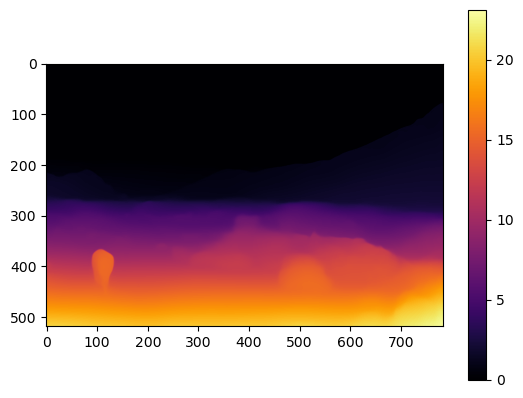

In [9]:
import matplotlib.pyplot as plt

plt.imshow(depth.squeeze().cpu().detach().numpy(), cmap='inferno')
plt.colorbar()
plt.savefig('Saved Images/depth.png', bbox_inches='tight', pad_inches=0)
plt.show()


In [ ]:
print(depth)